Пришло время проанализировать результаты эксперимента, который мы провели вместе с командой дата сайентистов. Эксперимент проходил с 2024-01-26 по 2024-02-01 включительно. Для эксперимента были задействованы 2 и 1 группы. 

В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 

Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 

Ваша задача — проанализировать данные А/B-теста. 

- Выбрать метод анализа и сравнить CTR в двух группах (мы разбирали t-тест, Пуассоновский бутстреп, тест Манна-Уитни, t-тест на сглаженном ctr (α=5) а также t-тест и тест Манна-Уитни поверх бакетного преобразования).
- Сравните данные этими тестами. А еще посмотрите на распределения глазами. Почему тесты сработали именно так? 
- Опишите потенциальную ситуацию, когда такое изменение могло произойти. Тут нет идеального ответа, подумайте.
- Напишите рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит.

In [25]:
import pandahouse
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [14]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_'
}


In [51]:
q = """
select 
    exp_group,
    user_id,
    sum(action = 'like') as like,
    sum(action = 'view') as view,
    like / view as ctr
from simulator_20240220.feed_actions
where time between '2024-01-26' and '2024-02-01' and exp_group in (1, 2)
group by user_id, exp_group
"""

df = pandahouse.read_clickhouse(q, connection=connection)
df.head()

,exp_group,user_id,like,view,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,18392,7,32,0.218750
4,1,26295,29,109,0.266055


<Axes: xlabel='ctr', ylabel='Count'>

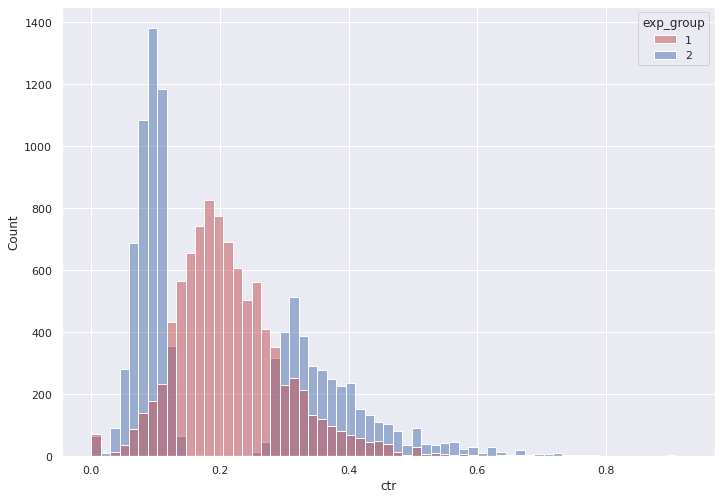

In [66]:
#Посмотрим график распределения ctr двух групп

sns.set(rc={'figure.figsize':(11.7, 8.27)})
sns.histplot(data = df,
            x = 'ctr',
            hue = 'exp_group',
            palette = ['r', 'b'],
            alpha = 0.5,
            kde = False)

**График распределения ctr говорит о разном поведении в группах: в группе 1 нормальное распределение, а во 2-й оно делится на две подгуппы, "разрываясь" в районе 0.2ctr**

In [23]:
#Проведем t-test

stats.ttest_ind(df[df.exp_group == 1].ctr,
               df[df.exp_group == 2].ctr,
               equal_var=False)

Ttest_indResult(statistic=0.5362098121273291, pvalue=0.5918218427419477)

**T-test не заметил разницу между группами, p_value = 0.59**

In [24]:
#Тест Манна-Уитни

stats.mannwhitneyu(df[df.exp_group == 1].ctr,
                   df[df.exp_group == 2].ctr)

MannwhitneyuResult(statistic=49702070.0, pvalue=3.4218087630007513e-67)

**Исследование по Манну-Уитни заметило существенную разницу в ctr между нашими группами, p_value стремится к нулю**

In [49]:
#Пуассоновский бутстреп

def bootstrap(likes1, views1, likes2, views2, n_bootstrap = 2000):
    poisson_bootstrap1 = stats.poisson(1).rvs((n_bootstrap, len(likes1))).astype(np.int64)
    poisson_bootstrap2 = stats.poisson(1).rvs((n_bootstrap, len(likes2))).astype(np.int64)
    global_ctr1 = (poisson_bootstrap1 * likes1).sum(axis=1) / (poisson_bootstrap1 * views1).sum(axis=1)
    global_ctr2 = (poisson_bootstrap2 * likes2).sum(axis=1) / (poisson_bootstrap2 * views2).sum(axis=1)
    return global_ctr1, global_ctr2

In [52]:
likes1 = df[df.exp_group == 1].like.to_numpy()
views1 = df[df.exp_group == 1].view.to_numpy()
likes2 = df[df.exp_group == 2].like.to_numpy()
views2 = df[df.exp_group == 2].view.to_numpy()

In [53]:
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

<Axes: ylabel='Count'>

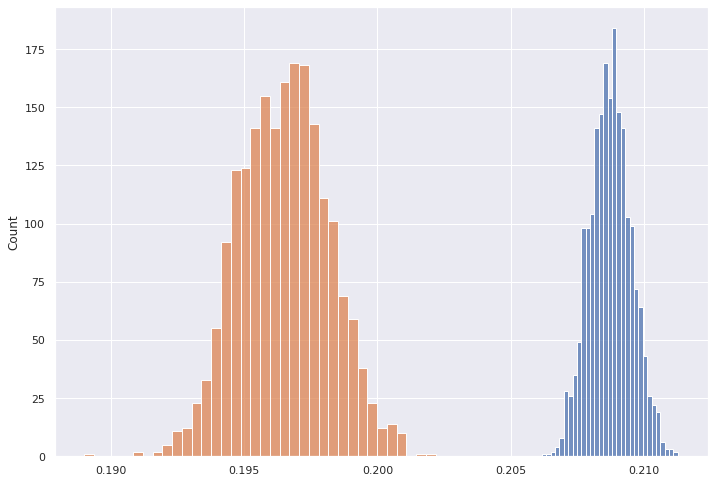

In [54]:
sns.histplot(ctr1)
sns.histplot(ctr2)

<Axes: ylabel='Count'>

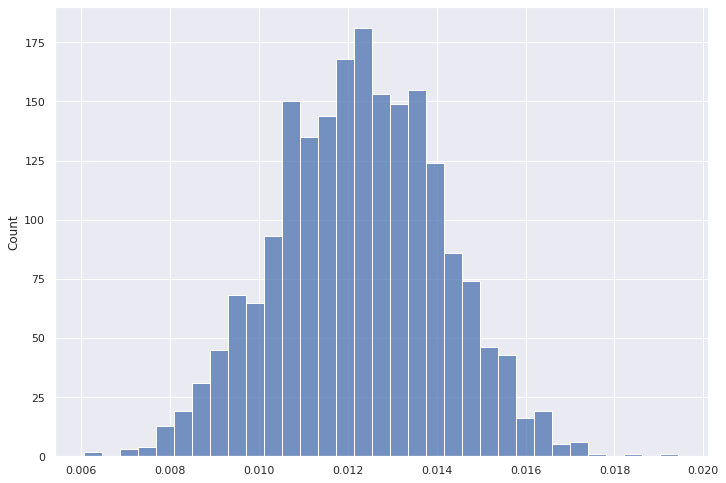

In [55]:
sns.histplot(ctr1 - ctr2)

**Исследование двух групп по Пуассоновскому бутстрепу показало, что ctr первой, контрольной, группы строго больше, чем ctr второй, исследуемой, группы**

In [58]:
#T-test со сглаженным CTR
#Функция для сглаживания CTR

def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [57]:
#Считаем общий ctr для обеих групп

global_ctr1 = df[df.exp_group == 1].like.sum() / df[df.exp_group == 1].view.sum()
global_ctr2 = df[df.exp_group == 2].like.sum() / df[df.exp_group == 2].view.sum()

In [73]:
#Создаем копию датафрейма с пользователями из первой и второй групп

group1 = df[df.exp_group == 1].copy()
group2 = df[df.exp_group == 2].copy()

/tmp/ipykernel_54/1247024139.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(group1.ctr, kde = False)


<Axes: xlabel='ctr'>

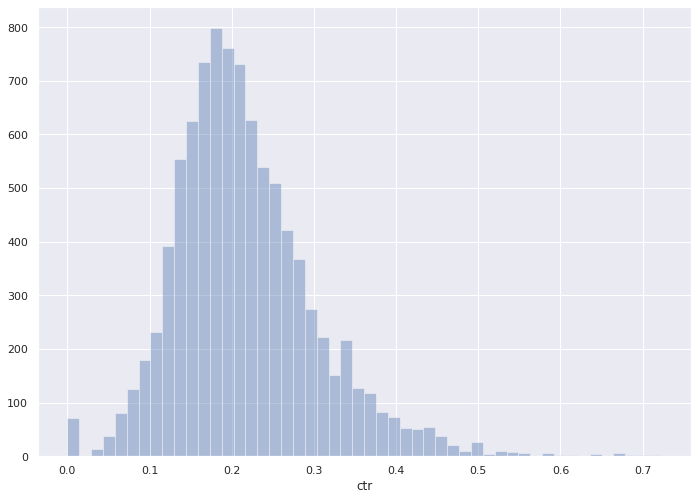

In [74]:
sns.distplot(group1.ctr, kde = False)

/tmp/ipykernel_54/3173137597.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(group2.ctr, kde = False)


<Axes: xlabel='ctr'>

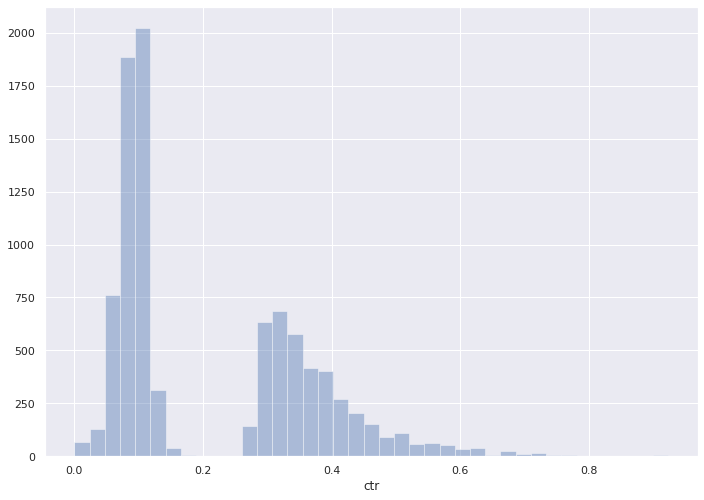

In [70]:
sns.distplot(group2.ctr, kde = False)

In [80]:
#Применяем функцию сглаживания для новых датафреймов

group1['smothed_ctr'] = df.apply(lambda x: get_smothed_ctr(x['like'], x['view'], global_ctr1, 5), axis=1)
group2['smothed_ctr'] = df.apply(lambda x: get_smothed_ctr(x['like'], x['view'], global_ctr2, 5), axis=1)

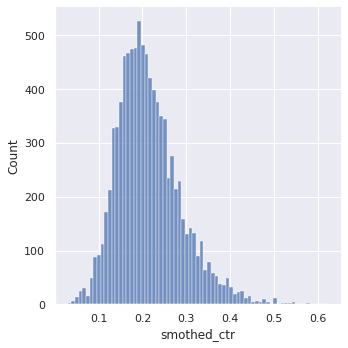

In [81]:
sns.displot(group1.smothed_ctr, kde = False)

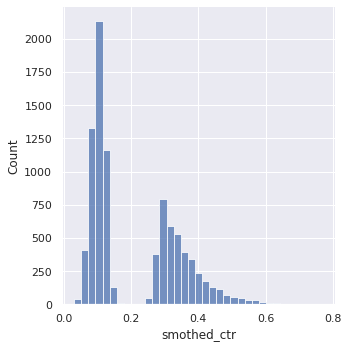

In [82]:
sns.displot(group2.smothed_ctr, kde = False)

In [84]:
#Проводим t-test с нашими новыми группами

stats.ttest_ind(group1.smothed_ctr,
               group2.smothed_ctr,
               equal_var=False)

Ttest_indResult(statistic=2.3999590748622235, pvalue=0.016409722243995145)

**T-test со сглаживаем показал статистически значимые отличия между исследуемыми группами с p_value 0.016**

In [92]:
#Бакетное преобразование 

qq = """

SELECT 
    exp_group, 
    bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT 
        exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM simulator_20240220.feed_actions 
    WHERE toDate(time) between '2024-01-26' and '2024-02-01' and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df_buck = pandahouse.read_clickhouse(qq, connection=connection)

In [93]:
#С помощью теста Манна-Уитни

stats.mannwhitneyu(df_buck[df_buck.exp_group == 1].bucket_ctr, 
                   df_buck[df_buck.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1997.0, pvalue=2.6576427804010095e-07)

**Тест Манна-Уитни с бакетным преобразованием видит статистически значимые различия между группами, p_value меньше 0.05**

In [95]:
#С помощью t-test

stats.ttest_ind(df_buck[df_buck.exp_group == 1].bucket_ctr,
           df_buck[df_buck.exp_group == 2].bucket_ctr,
           equal_var = False)

Ttest_indResult(statistic=5.614819358149381, pvalue=4.592644937473873e-07)

**T-test с бакетным преобразованием так же увидет статистически значимые различия между исследуемыми группами**

## Выводы по исследованию

Новый алгоритм рекомендации постов уронил CTR в своей экспериментальной группе. Насколько можно видеть по графикам - он работает некорректно. Есть предположение, что он предлагает рекомендации не по интересам пользователей, а посты какой-то одной похожей тематики, что может быть оправдано провалом метрики CTR на уровне около 0.2: эта тема либо очень нравится части пользователей (CTR > 0.3), либо, в большей степени, не интересна и ее не лайкают (CTR < 0.2).  
**Я бы не рекомендовал раскатывать новый алгоритм на основу, он требует доработки**